# Машинное обучение в бизнесе
# Определение региона для бурения новой нефтяной скважины

## Описание проекта
Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.  
Шаги для выбора локации обычно такие:
- В избранном регионе собирают характеристики для скважин: качество нефти и объём её запасов;
- Строят модель для предсказания объёма запасов в новых скважинах;
- Выбирают скважины с самыми высокими оценками значений;
- Определяют регион с максимальной суммарной прибылью отобранных скважин.

Вам предоставлены пробы нефти в трёх регионах. Характеристики для каждой скважины в регионе уже известны. Постройте модель для определения региона, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой Bootstrap.

## Описание данных
Данные геологоразведки трёх регионов находятся в файлах:
- geo_data_0.csv
- geo_data_1.csv
- geo_data_2.csv

**id** — уникальный идентификатор скважины;  
**f0, f1, f2** — три признака точек (неважно, что они означают, но сами признаки значимы);  
**product** — объём запасов в скважине (тыс. барр.).  

Условия задачи:
- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
- При разведке региона исследуют 500 точек, из которых выбирают 200 лучших для расчёта прибыли.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- Один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах барр..
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

## Шаг 1. Загрузите и подготовьте данные. Поясните порядок действий.

In [1]:
# Импорт нужных библиотек и классов

# Общие библиотеки
import pandas as pd
import numpy as np
# Seaborn для графиков
import seaborn as sns
# Разделение на обучающую и тестовую выборки
from sklearn.model_selection import train_test_split
# Масштабирование
from sklearn.preprocessing import StandardScaler
# Модель линейной регрессии
from sklearn.linear_model import LinearRegression
# MSE
from sklearn.metrics import mean_squared_error
# Для расчёта доверительного интервала
from scipy import stats as st

In [2]:
region_0_df = pd.read_csv('geo_data_0.csv')
region_1_df = pd.read_csv('geo_data_1.csv')
region_2_df = pd.read_csv('geo_data_2.csv')

In [3]:
region_0_df.info()
region_1_df.info()
region_2_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8

In [4]:
# Вывод первых 10 строк первого датасета для ознакомления
region_0_df.head(10)

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647
5,wX4Hy,0.969570,0.489775,-0.735383,64.741541
6,tL6pL,0.645075,0.530656,1.780266,49.055285
7,BYPU6,-0.400648,0.808337,-5.624670,72.943292
8,j9Oui,0.643105,-0.551583,2.372141,113.356160
9,OLuZU,2.173381,0.563698,9.441852,127.910945


Видим, что 3 датасета содержат в себе полный набор данных по всем столбцам, из которых 4 столбца имеют вещественный тип, а один (id) имеет тип object и там хранятся уникальные строки-идентификаторы скважин. В рамках выполнения данного проекта можем отказаться от использования столбца id. В дальнейшем, после разбиения данных на обучающие и валидационные выборки можно будет провести масштабирование данных.

In [5]:
region_0_df = region_0_df.drop('id', axis=1)
region_1_df = region_1_df.drop('id', axis=1)
region_2_df = region_2_df.drop('id', axis=1)

## Шаг 2. Обучите и проверьте модель для каждого региона.
### 2.1. Разбейте данные на обучающую и валидационную выборки в соотношении 75:25.

In [6]:
# Функция масштабирования датасета
def df_transform(df, scaler):
    scaled_array = scaler.transform(df)
    return pd.DataFrame(scaled_array, index=df.index, columns=df.columns)

# Функция разбиения датасета на обучающую и валидационную выборки и масштабирование признаков
def split_and_scaling_data(df):
    features = df.drop(['product'], axis=1)
    target = df['product']
    features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.25, random_state=12345)
    scaler = StandardScaler()
    scaler.fit(features_train)
    features_train = df_transform(features_train, scaler)
    features_valid = df_transform(features_valid, scaler)
    return features_train, features_valid, target_train, target_valid

In [7]:
# Разобьем на выборки наши 3 датасета
features_train_0, features_valid_0, target_train_0, target_valid_0 = split_and_scaling_data(region_0_df)
features_train_1, features_valid_1, target_train_1, target_valid_1 = split_and_scaling_data(region_1_df)
features_train_2, features_valid_2, target_train_2, target_valid_2 = split_and_scaling_data(region_2_df)

### 2.2. Обучите модель и сделайте предсказания на валидационной выборке.
Выберём для обучения модель линейной регрессии, т.к. она указана в условиях проекта.

In [8]:
# Функция обучает модель линейной регрессии и возвращает предсказанные целевые признаки
def predict(features_train, features_valid, target_train):
    model = LinearRegression()
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    return pd.Series(predicted_valid, index=features_valid.index)

In [9]:
predicted_valid_0 = predict(features_train_0, features_valid_0, target_train_0)
predicted_valid_1 = predict(features_train_1, features_valid_1, target_train_1)
predicted_valid_2 = predict(features_train_2, features_valid_2, target_train_2)

### 2.3. Сохраните предсказания и правильные ответы на валидационной выборке.

Предсказания и правильные ответы валидационной сборки храним в переменных:
- predicted_valid_0, target_valid_0 - для первого датасета
- predicted_valid_1, target_valid_1 - для второго датасета
- predicted_valid_2, target_valid_2 - для третьего датасета

### 2.4. Напечатайте на экране средний запас предсказанного сырья и RMSE модели.

In [10]:
# Функция определения среднего значения предсказанного целевого признака и RMSE модели
def mean_and_rmse(predicted_valid, target_valid, number):
    mse = mean_squared_error(target_valid, predicted_valid)
    rmse = mse ** 0.5
    predicted_valid_mean = predicted_valid.mean()
    print('По датасету {number} имеем средний запас предсказанного сырья на 1 скважину {predicted_valid_mean:.2f} тыс. барр. и rmse={rmse:.2f}'.format(
        number=number, predicted_valid_mean=predicted_valid_mean, rmse=rmse
        )
    )

In [11]:
mean_and_rmse(predicted_valid_0, target_valid_0, 1)
mean_and_rmse(predicted_valid_1, target_valid_1, 2)
mean_and_rmse(predicted_valid_2, target_valid_2, 3)

По датасету 1 имеем средний запас предсказанного сырья на 1 скважину 92.59 тыс. барр. и rmse=37.58
По датасету 2 имеем средний запас предсказанного сырья на 1 скважину 68.73 тыс. барр. и rmse=0.89
По датасету 3 имеем средний запас предсказанного сырья на 1 скважину 94.97 тыс. барр. и rmse=40.03


### 2.5. Проанализируйте результаты.
Видим, что по датасету 2 мы имеем самый низкий запас предсказанного сырья, но в нём также самая низкая метрика rmse - всего 0.89, тогда как у других 2 датасетов эта метрика около 40 тыс. барр..

## Шаг 3. Подготовьтесь к расчёту прибыли.
### 3.1. Все ключевые значения для расчётов сохраните в отдельных переменных.

In [12]:
# Бюджет на 1 регион
budget_for_region = 10**10
# Доход с 1 тыс. барр.
income_for_1_product = 450000
# Количество скважин на бурение
wells_to_drill = 200
# Количество скважин для разведки
wells_to_analyze = 500;

### 3.2. Рассчитайте достаточный объём сырья для безубыточной разработки новой скважины. Сравните полученный объём сырья со средним запасом в каждом регионе.

In [13]:
product_for_drilling_one_well = budget_for_region / wells_to_drill / income_for_1_product
print('Для безубыточной разработки одной скважины требуется {product:.2f} тыс. барр.'.format(product=product_for_drilling_one_well))

Для безубыточной разработки одной скважины требуется 111.11 тыс. барр.


### 3.3. Напишите выводы по этапу подготовки расчёта прибыли.
Значение запаса одной скважины для безубыточной разработки больше всех предсказанных запасов на одну скважину в каждом регионе (92, 68 и 94 тыс. барр.).
Значит нужно бурить новые скважины только в тех местах, где запасы будут явно больше 111.11 тыс. барр.

## Шаг 4. Напишите функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели.
### 4.1. Выберите скважины с максимальными значениями предсказаний. Количество скважин зависит от бюджета компании и стоимости разработки одной скважины.
### 4.2. Просуммируйте целевое значение объёма сырья, соответствующее этим предсказаниям.
### 4.3. Рассчитайте прибыль для полученного объёма сырья.

In [14]:
# Функция расчёта прибыли по well_count лучшим предсказанным и выбранным по ним реальным скважинам
def revenue(target, predicted, well_count):
    predicted_sorted = predicted.sort_values(ascending=False)
    selected = target[predicted_sorted.index][:well_count]
    return selected.sum() * income_for_1_product - budget_for_region

## Шаг 5. Посчитайте риски и прибыль для каждого региона.
### 5.1. Примените технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.

In [15]:
# Функция поиска распределения прибыли с помощью техники Bootstrap
def bootstrap_revenue_values(target, predicted):
    values = []
    state = np.random.RandomState(12345)
    for i in range(1000):
        target_subsample = target.sample(n=wells_to_analyze, replace=True, random_state=state)
        predicted_subsample = predicted[target_subsample.index]
        values.append(revenue(target_subsample, predicted_subsample, wells_to_drill))
    return pd.Series(values)

# Найдем распределение прибыли по регионам
revenue_values_0 = bootstrap_revenue_values(target_valid_0, predicted_valid_0)
revenue_values_1 = bootstrap_revenue_values(target_valid_1, predicted_valid_1)
revenue_values_2 = bootstrap_revenue_values(target_valid_2, predicted_valid_2)

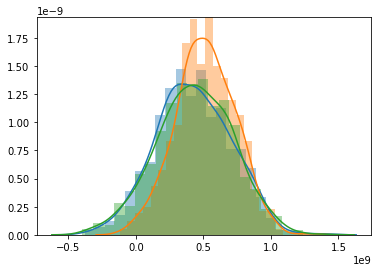

In [16]:
# Построим распределение прибыли на графике
sns.distplot(revenue_values_0)
sns.distplot(revenue_values_1)
sns.distplot(revenue_values_2)

Видим, что в прибыль в большинстве случаев выборок положительная, но есть также и убыточные варианты.

### 5.2. Найдите среднюю прибыль, 95%-й доверительный интервал и риск убытков. Убыток — это отрицательная прибыль.

In [17]:
# Функция расчёта средней прибыли, доверит. интервала и риска убытков
def final_params_calc(revenue_values, region_num):
    mean_revenue = revenue_values.mean()
    confidence_interval = st.t.interval(
        0.95, len(revenue_values)-1, revenue_values.mean(), revenue_values.sem())
    loss_risk = len(revenue_values[revenue_values < 0]) / len(revenue_values)

    print(
       'Средняя прибыль пр региону {num} равна {mean_:.2f} млн. рублей, 95% доверительный интервал ({beg:.2f}, {end:.2f}) млн. рублей и риск убытков {lr:.1%}'.format(
           num = region_num, mean_ = mean_revenue / 10**6, beg = confidence_interval[0] / 10**6, end = confidence_interval[1] / 10**6, lr = loss_risk
       )
    )
    return mean_revenue, confidence_interval, loss_risk

final_params_0 = final_params_calc(revenue_values_0, 1)
final_params_1 = final_params_calc(revenue_values_1, 2)
final_params_2 = final_params_calc(revenue_values_2, 3)

Средняя прибыль пр региону 1 равна 425.94 млн. рублей, 95% доверительный интервал (408.73, 443.14) млн. рублей и риск убытков 6.0%
Средняя прибыль пр региону 2 равна 515.22 млн. рублей, 95% доверительный интервал (501.62, 528.82) млн. рублей и риск убытков 1.0%
Средняя прибыль пр региону 3 равна 435.01 млн. рублей, 95% доверительный интервал (417.45, 452.56) млн. рублей и риск убытков 6.4%


### 5.3. Напишите выводы: предложите регион для разработки скважин и обоснуйте выбор.

Как видно из выводов самый выгодный регион для разработки это второй регион. Он имеет доверительный интервал с самой большой прибылью, среднее значение у него также больше и самый главный аргумент - риск убытков у него менее 2.5% (всего 1%).
Если вспомнить результаты, полученные в результате обучения модели линейной регрессии, то на этом регионе так же была самая низкая ошибка rmse.